# LSTM Models for TKN Prediction in Influent Wastewater

Model Iteration No. 1 - This code uses all project feature inputs (BOD5, CBOD5, VTS, SS, VSS, TS, P-TOT, P-SOL). This code served as the first step prior to SHAP value evaluations. See Appendix E for Model Iteration No. 2 which is the final project model.

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
# from utils import * 

import sklearn as sk
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [30]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# Import the Data

In [94]:
influent = pd.read_excel(r"C:\Users\18455\EAEE4000_ML_Jupyter\EAEE4000_WW_Prediction\Appendix_A_Preprocessing_and_DataReview\raw_influent.xlsx")
influent['Year']= influent['Date'].apply(lambda x: x.year)
influent['Year'] = influent['Year'].astype(int)
influent

,Unnamed: 0,Date,BOD5,CBOD5,SS,VSS,TS,VTS,TKN,Nitrates,P-TOT,P-SOL,Year
0,2672,2008-01-01,67,55,82,64,1994,188,18.53,0.72,2.65,1.155,2008
1,2673,2008-01-02,77,57,70,61,1274,196,19.87,0.85,4.22,2.849,2008
2,2674,2008-01-03,94,70,84,69,1096,220,21.49,0.81,5.53,3.809,2008
3,2675,2008-01-04,93,64,72,54,1003,242,19.32,0.65,6.19,4.107,2008
4,2676,2008-01-05,107,75,118,90,1317,280,17.13,0.31,4.16,2.183,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,7706,2019-12-27,0,0,79,61,554,174,14.00,0.66,3.05,1.310,2019
4379,7707,2019-12-28,62,51,48,37,570,130,18.00,0.76,4.47,2.170,2019
4380,7708,2019-12-29,189,115,340,224,962,340,17.00,0.49,4.55,1.240,2019
4381,7709,2019-12-30,74,47,99,68,656,164,14.00,0.88,2.70,1.070,2019


# Prepare the Training Data

See all project input features used here.

In [95]:
# Prepare the training set
X = influent[['SS','VSS','VTS','TS','BOD5','CBOD5','P-TOT','P-SOL']]
Y = influent[['TKN']]
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X, Y,
        test_size = 0.2, random_state=2, shuffle=False) # Shuffle is false to prevent shuffling the whole training dataset as split cannot shuffle time series data

In [96]:
# Normalize the data
mean_x, std_x = X_train_df.mean(), X_train_df.std()
mean_y, std_y = Y_train_df.mean(), Y_train_df.std()

X_train_df = (X_train_df - mean_x)/std_x
X_test_df  = (X_test_df - mean_x)/std_x

Y_train_df = (Y_train_df - mean_y)/std_y
Y_test_df  = (Y_test_df - mean_y)/std_y

X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

X_test = X_test_df.to_numpy()
Y_test = Y_test_df.to_numpy()

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape, )

(3506, 8) (3506, 1)
(877, 8) (877, 1)


# Reshape the Data for LSTM Model Input

In [97]:
# Reshape the data to prepare for LSTM Model use.
# Format: samples, time steps, features

X = X_train
Y = Y_train

Xt = X_test
# Yt = Y_test

X_reshape = []
Y_reshape = []
Xt_reshape = []
# Yt_reshape = []

sequence_length = 4 # time step

In [98]:
for index in range(len(X)- sequence_length):
    X_reshape.append(X[index: index + sequence_length])
X_reshape = np.array(X_reshape)
X_train = X_reshape
print(X_train.shape)

(3502, 4, 8)


In [99]:
for index in range(len(Y) - sequence_length):
    Y_reshape.append(Y[index: index + sequence_length])
Y_reshape = np.array(Y_reshape)
Y_train = Y_reshape
print(Y_train.shape)

(3502, 4, 1)


In [100]:
for index in range(len(Xt) - sequence_length):
    Xt_reshape.append(Xt[index: index + sequence_length])
Xt_reshape = np.array(Xt_reshape)
X_test = Xt_reshape
print(X_test.shape)

(873, 4, 8)


In [101]:
Y_test = Y_test_df.iloc[4:]
print(Y_test.shape)

(873, 1)


# Set Hyperparameters and Model Architecture

In [161]:
# set hyperparameters
n_neuron       = 24
activation     = 'relu' # best performing act function
num_epochs     = 20
learning_rate  = 0.005
minibatch_size = 50 
model_num      = 1
params         = 8 # these are the number of features included in the reshaped data (samples, time step, features)

In [162]:
lstm_model = Sequential()

lstm_model.add(LSTM(n_neuron,input_shape=(sequence_length, params),return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(n_neuron,activation='Softmax'))
#lstm_model.add(Dense(n_neuron,activation=activation)) # Not used - determined additional layers did not improve accuracy
#lstm_model.add(Dense(n_neuron,activation=activation))
#lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(1)) #, activation='softmax') 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [163]:
lstm_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 4, 24)             3168      
                                                                 
 lstm_35 (LSTM)              (None, 24)                4704      
                                                                 
 dense_51 (Dense)            (None, 24)                600       
                                                                 
 dense_52 (Dense)            (None, 24)                600       
                                                                 
 dense_53 (Dense)            (None, 1)                 25        
                                                                 
Total params: 9,097
Trainable params: 9,097
Non-trainable params: 0
_________________________________________________________________


# Evaluate the Model

In [164]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = lstm_model.fit(X_train, Y_train, 
                    #batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1, 
                    callbacks       = [early_stop])

Epoch 1/20
88/88 [==============================] - 5s 15ms/step - loss: 0.6493 - val_loss: 1.5634
Epoch 2/20
88/88 [==============================] - 1s 9ms/step - loss: 0.6034 - val_loss: 1.4572
Epoch 3/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5881 - val_loss: 1.3814
Epoch 4/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5867 - val_loss: 1.3281
Epoch 5/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5718 - val_loss: 1.2575
Epoch 6/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5715 - val_loss: 1.2042
Epoch 7/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5571 - val_loss: 1.1410
Epoch 8/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5506 - val_loss: 1.0993
Epoch 9/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5439 - val_loss: 1.0369
Epoch 10/20
88/88 [==============================] - 1s 9ms/step - loss: 0.5389 - val_loss: 0.9952
Epoch 11/20
88/88 

In [165]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
            label='Train loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
            label='Val loss')
    plt.legend()

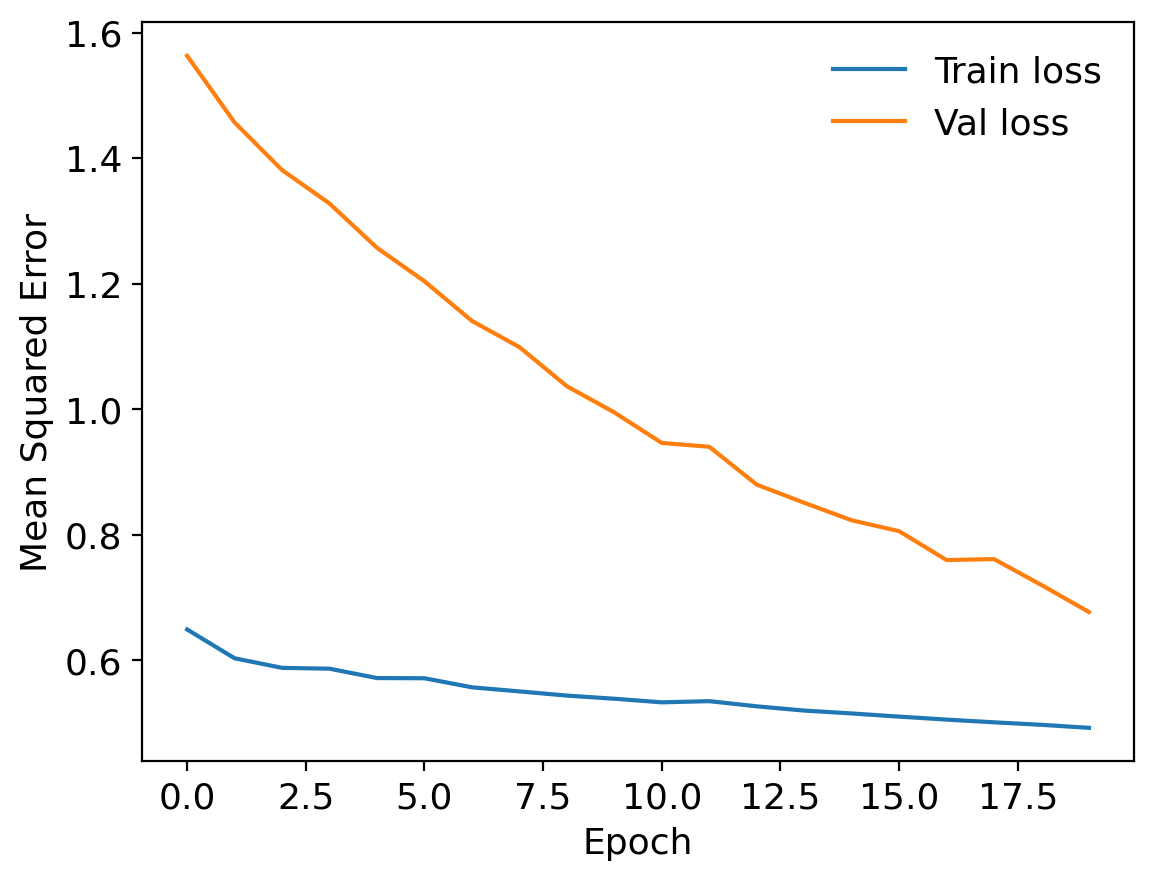

In [166]:
plot_history(history)

# Make Predictions

In [167]:
print(Y_test.shape)

(873, 1)


In [168]:
print(X_test.shape)

(873, 4, 8)


In [169]:
y_test_predict = lstm_model.predict(X_test) # check how it does for X_train set...if still getting same numbers may be over/underfitting
y_test_predict

28/28 [==============================] - 0s 3ms/step


array([[ 8.96042585e-01],
       [ 1.01938939e+00],
       [ 1.04903293e+00],
       [ 1.19868708e+00],
       [ 1.00910151e+00],
       [ 1.00611115e+00],
       [ 1.03072524e+00],
       [ 9.67041612e-01],
       [ 8.89755070e-01],
       [ 8.69458795e-01],
       [ 1.00708628e+00],
       [ 1.20276439e+00],
       [ 1.37592006e+00],
       [ 1.25782490e+00],
       [ 1.23579144e+00],
       [ 1.10821962e+00],
       [ 9.20634568e-01],
       [ 9.70512748e-01],
       [ 9.75914717e-01],
       [ 1.08205163e+00],
       [ 1.21794522e+00],
       [ 1.22055793e+00],
       [ 1.16205692e+00],
       [ 8.90875876e-01],
       [ 8.17699909e-01],
       [ 1.11992621e+00],
       [ 1.20593190e+00],
       [ 1.05943191e+00],
       [ 8.50709915e-01],
       [ 6.47531092e-01],
       [ 5.39157629e-01],
       [ 5.68188429e-01],
       [ 6.62910163e-01],
       [ 6.50249302e-01],
       [ 5.50983131e-01],
       [ 6.09032869e-01],
       [ 6.30864561e-01],
       [ 5.17816901e-01],
       [ 3.0

In [170]:
print(y_test_predict.shape)

(873, 1)


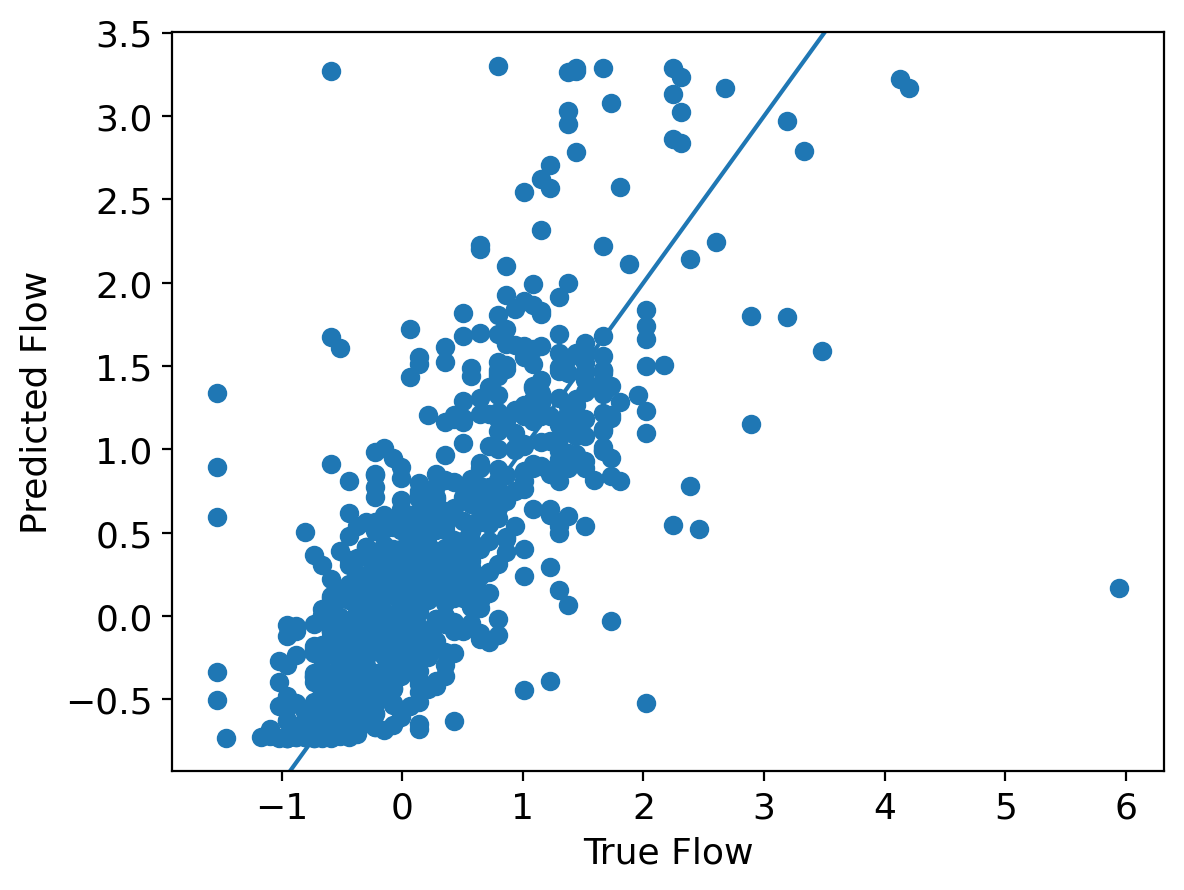

In [171]:
plt.scatter(Y_test, y_test_predict) # this is where y_test comes into play...to backcheck the correct answers
plt.xlabel('True Flow')
plt.ylabel('Predicted Flow')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [172]:
# Calculate predictions & associated Mean Squared Error
mse(Y_test, y_test_predict)

0.37137446677808467

In [27]:
# print out the prediction scores
print('MSE: {}'.format(mse(Y_test, y_test_predict)))
print('RMSE: {}'.format(np.sqrt(mse(Y_test, y_test_predict))))
print('MAE: {}'.format(mae(Y_test, y_test_predict)))
print('R-SQ: {}'.format(r2_score(Y_test, y_test_predict)))

MSE: 0.3676394143651847
RMSE: 0.6063327587762224
MAE: 0.3962578208870728
R-SQ: 0.5501527024444565
